# CNN with MNIST #

## Lab 06 : Convolutional Neural Networks ##

### MNIST Dataset ###
지난번에 사용했던 MNIST Dataset을 다시 불러올게요!

In [26]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

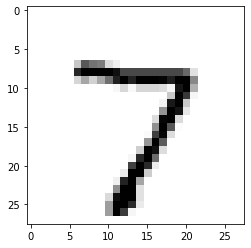

In [27]:
mnist_train = dsets.MNIST(root="dataset/MNIST_data/",
                          train=True,
                          transform=transforms.ToTensor(), 
                          download=True)
mnist_test = dsets.MNIST(root="dataset/MNIST_data/",
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

plt.imshow(mnist_test.test_data[0].view(28, 28), cmap='Greys', interpolation='nearest')

## CNN을 구현해봅시다.

In [28]:
import torch
import torch.nn as nn

class CNN(nn.Module): # 모델에 대한 내용은 방학때 자세히 알아보도록 해요.
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1)
        )
        self.l1after = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        )
        self.l2after = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 앞에서 본 fully-connected 레이어네요!
        self.fc1 = nn.Linear(3136, 128, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)        
    
    def forward(self, x):
        out = self.l1after(self.layer1(x))
        out = self.l2after(self.layer2(out))
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out 
    
    # 이 아래는 각 레이어가 무슨 역할을 하는지 알아보기 위해 만들었어요.
    def firstconv(self, x):
        return self.layer1(x)
    
    def secondconv(self, x):
        out = self.l1after(self.layer1(x))
        out = self.layer2(out)
        return out

## 학습을 시키기 위한 준비를 해보아요

In [29]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                         batch_size=64,
                                         shuffle=True,
                                         drop_last=True) # 데이터를 불러오기 위한 데이터로더입니다!

device = 'cuda' if torch.cuda.is_available() else 'cpu' # gpu를 사용한다면 장치를 gpu로 바꾸어줍시다.
print('지금 사용하고 있는 장치는',device,'입니다.')

model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

지금 사용하고 있는 장치는 cuda 입니다.


## 학습 전 정확도를 살펴보겠습니다.

In [30]:
import numpy as np
def print_acc():
    with torch.no_grad():
        X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
        Y_test = mnist_test.targets.to(device)

        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        print('Accuracy: ',accuracy.item()*100,"%")

print_acc()

Accuracy:  11.499999463558197 %


## 학습을 시켜볼게요.

학습이 시작되었습니다.
Epoch:01 loss = 0.15857680141925812
Epoch:02 loss = 0.04773486405611038
Epoch:03 loss = 0.03212347999215126
Epoch:04 loss = 0.024318380281329155
Epoch:05 loss = 0.01628822274506092
Epoch:06 loss = 0.014017275534570217
Epoch:07 loss = 0.012296517379581928
Epoch:08 loss = 0.00985244195908308
Epoch:09 loss = 0.008011664263904095
Epoch:10 loss = 0.0067918431013822556
Epoch:11 loss = 0.0060121542774140835
Epoch:12 loss = 0.0056782616302371025
Epoch:13 loss = 0.004702662583440542
Epoch:14 loss = 0.0049149938859045506
Epoch:15 loss = 0.004380341619253159
학습이 종료되었습니다.


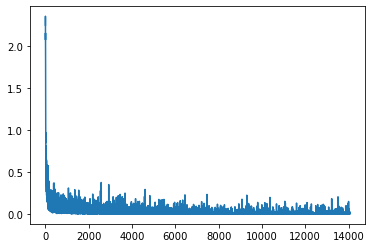

In [31]:
total_batch = len(data_loader)
losses = []
epochs = 15
print('학습이 시작되었습니다.')

for epoch in range(epochs):
    avg_loss=0
    for X_data, Y_data in data_loader:
        X_data = X_data.to(device)
        Y_data = Y_data.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X_data)
        
        loss = criterion(hypothesis, Y_data)
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        avg_loss += loss/total_batch
    print('Epoch:{:02d} loss = {}'.format(epoch+1, avg_loss))
print('학습이 종료되었습니다.')
plt.plot(losses)

## 내부 과정을 살펴볼게요!

In [33]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def firstlayer():
    test_image = mnist_test.test_data[0].view(1,1,28, 28).to(device).float()
    firstconv = model.firstconv(test_image)[0].cpu().detach().numpy()

    plot_x = 6
    plot_y = 5

    img = test_image.cpu().detach().numpy()
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('First Convolution Layer')
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(firstconv[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

    plt.imshow(deprocess_image(firstconv)[0], cmap='gray')

def secondlayer():
    plot_x = 6
    plot_y = 5
    test_image = mnist_test.test_data[0].view(1,1,28, 28).to(device).float()
    secondconv = model.secondconv(test_image)[0].cpu().detach().numpy()
    img = test_image.cpu().detach().numpy()
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Second Convolution Layer')
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(secondconv[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

    plt.imshow(deprocess_image(secondconv)[0], cmap='gray')

### 첫번째 Layer의 모습입니다.

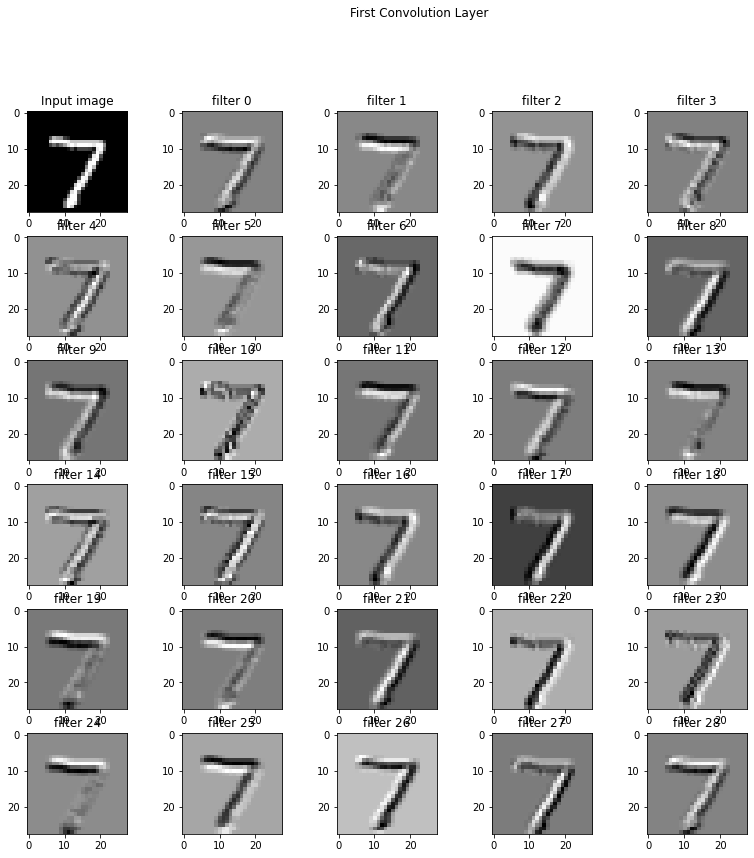

In [34]:
firstlayer()

### 두번째 Layer의 모습입니다.

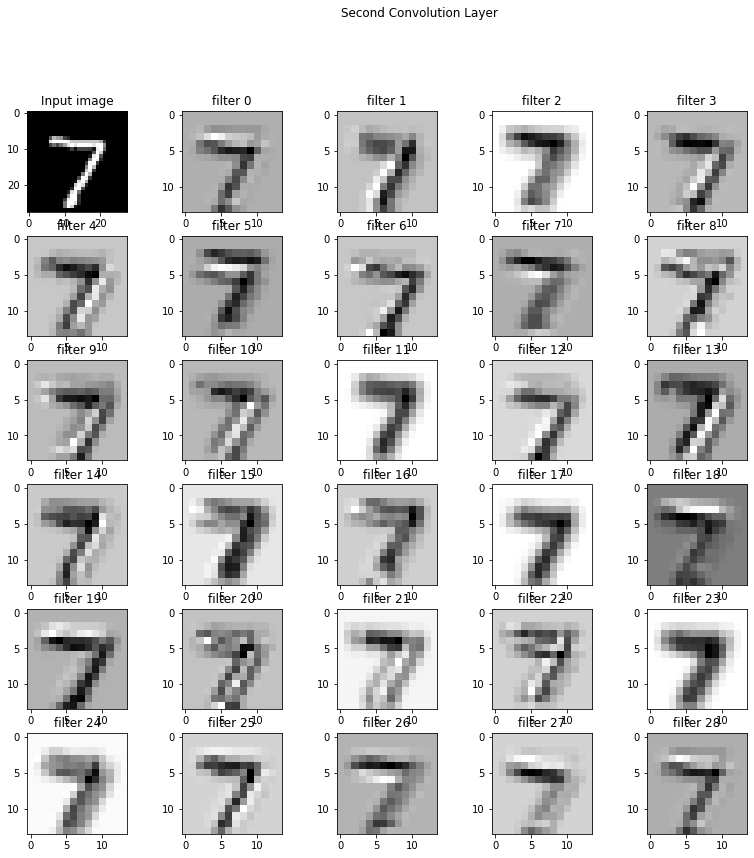

In [35]:
secondlayer()